In [1]:
import pandas as pd
from binance import Client
import snscrape.modules.twitter as sntwitter
import seaborn as sns
from deep_translator import GoogleTranslator
import datetime as dt
from gensim import corpora
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
from datetime import date




import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
sns.set() # use seaborn plotting style

ModuleNotFoundError: No module named 'binance'

In [ ]:
PUBLIC_KEY = 'WhihdXQmvY9QAObIELyVGAI3h1nvJZDYg1B68H7n0MHn0bISKXMwHozMcxMbaJ0Z'
PRIVATE_KEY = '2auNidRhbGrAG06UWK0MPcPYJtBj9fMFKpAWJsyjTACJLHHIdOHVbsLj8MZopJJ4'
client = Client(PUBLIC_KEY, PRIVATE_KEY)
tickers = client.get_all_tickers()
df = pd.DataFrame()
for coins in client.get_all_tickers():
    if((coins["symbol"][-4:]=="BUSD")):
        historical_data = client.get_historical_klines(
            coins["symbol"], Client.KLINE_INTERVAL_1DAY, '19 July 2022')
        coin_df = pd.DataFrame(historical_data,columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time',
                'Quote Asset Volume', 'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore'])
        coin_df["COIN"]=coins["symbol"][:-4]
        df = pd.concat([df,coin_df],axis=0)
df['Open Time'] = pd.to_datetime(df['Open Time']/1000, unit='s')
df['Close Time'] = pd.to_datetime(df['Close Time']/1000, unit='s')
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                   'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, axis=1)
df["Change"] = ((df["High"]-df["Low"])/df["Low"]).apply(lambda x: x*100)


In [ ]:
df = df.sort_values(by="Change",ascending=False)
df

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore,COIN,Change
0,2022-07-19,0.657000,1.073000,0.642000,0.711000,6.464697e+06,2022-07-19 23:59:59.999000072,5.273567e+06,30452,2.894885e+06,2.362180e+06,0,NEXO,67.133956
0,2022-07-19,0.004428,0.006838,0.004422,0.005716,1.857278e+09,2022-07-19 23:59:59.999000072,1.074377e+07,50191,8.804211e+08,5.086821e+06,0,MBL,54.635911
0,2022-07-19,0.714900,0.998100,0.700700,0.907600,7.353791e+06,2022-07-19 23:59:59.999000072,6.605193e+06,35318,3.479119e+06,3.125771e+06,0,YGG,42.443271
0,2022-07-19,0.012940,0.016570,0.012640,0.013370,1.507238e+08,2022-07-19 23:59:59.999000072,2.150307e+06,12887,7.516832e+07,1.068637e+06,0,ACH,31.091772
0,2022-07-19,0.210100,0.260000,0.202000,0.218200,7.163416e+06,2022-07-19 23:59:59.999000072,1.658351e+06,8807,3.787302e+06,8.807552e+05,0,UFT,28.712871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2022-07-19,1705.000000,1716.000000,1701.000000,1716.000000,1.050117e+03,2022-07-19 23:59:59.999000072,1.792044e+06,2699,5.019897e+02,8.568816e+05,0,PAXG,0.881834
0,2022-07-19,1.194000,1.203000,1.193000,1.201000,1.099696e+06,2022-07-19 23:59:59.999000072,1.316979e+06,4185,6.323825e+05,7.572354e+05,0,GBP,0.838223
0,2022-07-19,0.999900,1.000100,0.999900,1.000000,1.313583e+05,2022-07-19 23:59:59.999000072,1.313608e+05,332,2.719400e+04,2.719672e+04,0,TUSD,0.020002
0,2022-07-19,0.999900,1.000100,0.999900,1.000100,8.325520e+07,2022-07-19 23:59:59.999000072,8.325423e+07,8914,3.950727e+07,3.950764e+07,0,USDC,0.020002


In [ ]:
tweets_list1 = []
username_not_needed = ['dashfit_signal','moon_or_earth', 'Crypto3OT', 'abnormal_crypto']
begin_date = dt.date(2022, 6, 18)
end_date = dt.date(2022, 7, 18)
# >30 is not good do something else
for coin in df.loc[df["Change"] > 30, "COIN"]:
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper('#'+coin, begin_date, end_date).get_items()):
        if ((i < 1000)):
            if((tweet.user.username not in username_not_needed)):
                (tweets_list1.append([tweet.date, tweet.user.username,coin,GoogleTranslator('auto', 'en').translate(tweet.content)]))
        else:
            break
tweets_df1 = pd.DataFrame(tweets_list1, columns=['Datetime', 'Username', 'Coin', 'Text'])


In [ ]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
# current_date =date.today()
def text_cleaning(text):
    stop_free = ' '.join([word for word in text.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
    return normalized.split()

tweets_df1["Cleaned Text"]= tweets_df1["Text"].apply(text_cleaning)

In [ ]:
# tweets_df1 = pd.read_csv("19.csv")
# tweets_df1

In [5]:
df = pd.read_csv("Untitled spreadsheet - 11.csv")
df1 = df.drop(columns=["Unnamed: 0","Username","Coin","Text","Datetime"])
X = df1.iloc[:,1]
Y = df1.iloc[:,0]
# X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=.2)
# model = make_pipeline(TfidfVectorizer(lowercase=False), MultinomialNB())
# model.fit(X_train, Y_train)
X

0      ['biconomyexchange', 'market', 'stat', '🚀🚀🚀', ...
1      ['🌪🎯', 'amp', 'volume', 'cant', 'ignored', 'th...
2      ['look', 'like', 'kara', 'starting', 'fly', '🚀...
3      ['binance', 'btc', 'market', 'tvk', 'unusual',...
4      ['tvk', '🚀', 'morning', 'wished', 'this', 'mus...
                             ...                        
423    ['price', 'change', '📊', 'price', 'mblusdt', '...
424    ['rt', 'im', 'hosting', 'espys', 'mlb', 'star'...
425    ['🌙', 'signal', 'mbl', 'mblusdt', '▶', 'buy', ...
426    ['new', 'high', 'price', '📈', '🚀', 'mblusdt', ...
427    ['star', 'key', 'mat', 'httpstcohom3xkn87g', '...
Name: Cleaned Text, Length: 428, dtype: object

,Datetime,Username,Coin,Text,Cleaned Text,Result
0,2022-07-19 07:18:02+00:00,TheiaSupernova,NEXO,In case you’ve missed that dopamine rush while...,"[case, you’ve, missed, dopamine, rush, checkin...",[2]
1,2022-07-19 06:35:06+00:00,cryptology_4_u,NEXO,"Well, if you just bought $Nexo at $0.56 a coup...","[well, bought, nexo, 056, couple, day, ago, co...",[2]
2,2022-07-17 23:33:46+00:00,JeremyAntEth,NEXO,We need a call to action for impending disaste...,"[need, call, action, impending, disaster, nexo...",[2]
3,2022-07-19 07:15:11+00:00,DashingHodleR,NEXO,Woah.. Just got back from vacation and saw #NE...,"[woah, got, back, vacation, saw, nexo, 50, 😎, ...",[1]
4,2022-07-19 10:35:04+00:00,TheGemHunters,NEXO,Wilderworld is currently breaking back through...,"[wilderworld, currently, breaking, back, suppo...",[1]
...,...,...,...,...,...,...
453,2022-07-15 08:53:00+00:00,StakingAlerts,ACH,#RAY 60 Days\n#ICX 60 Days\n#ACH 30 Days\n❌#so...,"[ray, 60, day, icx, 60, day, ach, 30, day, ❌so...",[2]
454,2022-07-11 09:45:00+00:00,quadrapay,ACH,Rent Payment Service Provider Brings To You AC...,"[rent, payment, service, provider, brings, ach...",[2]
455,2022-07-09 05:12:16+00:00,alt_coiners,ACH,#AltCoiners Pump and Dump\n\n#ACH 6.53%⬆️\n#BA...,"[altcoiners, pump, dump, ach, 653⬆️, bal, 683⬆...",[1]
456,2022-07-16 16:03:02+00:00,blocklearning,ACH,"So maybe #ach is a scam, but they've fooled so...","[maybe, ach, scam, theyve, fooled, industry, b...",[2]


In [ ]:
tweets_df1

,Datetime,Username,Coin,Text,Cleaned Text,Result
0,2022-07-19 07:18:02+00:00,TheiaSupernova,NEXO,In case you’ve missed that dopamine rush while...,"[case, you’ve, missed, dopamine, rush, checkin...",[2]
1,2022-07-19 06:35:06+00:00,cryptology_4_u,NEXO,"Well, if you just bought $Nexo at $0.56 a coup...","[well, bought, nexo, 056, couple, day, ago, co...",[2]
2,2022-07-17 23:33:46+00:00,JeremyAntEth,NEXO,We need a call to action for impending disaste...,"[need, call, action, impending, disaster, nexo...",[2]
3,2022-07-19 07:15:11+00:00,DashingHodleR,NEXO,Woah.. Just got back from vacation and saw #NE...,"[woah, got, back, vacation, saw, nexo, 50, 😎, ...",[1]
4,2022-07-19 10:35:04+00:00,TheGemHunters,NEXO,Wilderworld is currently breaking back through...,"[wilderworld, currently, breaking, back, suppo...",[1]
...,...,...,...,...,...,...
453,2022-07-15 08:53:00+00:00,StakingAlerts,ACH,#RAY 60 Days\n#ICX 60 Days\n#ACH 30 Days\n❌#so...,"[ray, 60, day, icx, 60, day, ach, 30, day, ❌so...",[2]
454,2022-07-11 09:45:00+00:00,quadrapay,ACH,Rent Payment Service Provider Brings To You AC...,"[rent, payment, service, provider, brings, ach...",[2]
455,2022-07-09 05:12:16+00:00,alt_coiners,ACH,#AltCoiners Pump and Dump\n\n#ACH 6.53%⬆️\n#BA...,"[altcoiners, pump, dump, ach, 653⬆️, bal, 683⬆...",[1]
456,2022-07-16 16:03:02+00:00,blocklearning,ACH,"So maybe #ach is a scam, but they've fooled so...","[maybe, ach, scam, theyve, fooled, industry, b...",[2]


In [ ]:
tweets_df1.to_csv("19 test.csv")

[Text(0, 0, 'TheiaSupernova'),
 Text(1, 0, 'cryptology_4_u'),
 Text(2, 0, 'JeremyAntEth'),
 Text(3, 0, 'DashingHodleR'),
 Text(4, 0, 'TheGemHunters'),
 Text(5, 0, 'BCGameOfficial'),
 Text(6, 0, 'CryptoStonksBot'),
 Text(7, 0, 'O2GBN'),
 Text(8, 0, 'DJPirrA'),
 Text(9, 0, 'YieldTopia'),
 Text(10, 0, 'JunkoSu22993224'),
 Text(11, 0, 'Nftgoingcrazy'),
 Text(12, 0, 'SuperWhitten'),
 Text(13, 0, 'Coinwink'),
 Text(14, 0, 'Bruel92'),
 Text(15, 0, 'versemeta888'),
 Text(16, 0, 'realwwcrypto'),
 Text(17, 0, '_RedSeaMoses'),
 Text(18, 0, 'twobitmonkey'),
 Text(19, 0, 'Mohixan'),
 Text(20, 0, 'DustinLew'),
 Text(21, 0, 'leodevta'),
 Text(22, 0, '2cryptomaniac'),
 Text(23, 0, 'MEXC_Global'),
 Text(24, 0, 'BrokeBackAdam'),
 Text(25, 0, 'ShareCheck'),
 Text(26, 0, 'Whale_Sniper'),
 Text(27, 0, 'SmindCrypto'),
 Text(28, 0, 'crypto_olymp'),
 Text(29, 0, 'LoverPlaid'),
 Text(30, 0, 'Coinparticle'),
 Text(31, 0, 'TylerMasonEth'),
 Text(32, 0, 'stablkwon'),
 Text(33, 0, 'Ground_Zero2013'),
 Text(34, 0, 

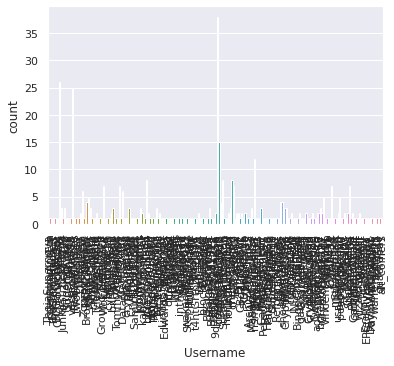

In [ ]:
sns.set(rc={'figure.figsize': (70, 20)})
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Username", data=tweets_df1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


In [ ]:
tweets_df1["Username"].value_counts()

HoefnagelsBjorn    38
O2GBN              26
versemeta888       25
crypto_whispers    15
nsmtloudspeaker    12
                   ..
Al44130557          1
inthecryptolab      1
unboozled           1
sellitforbtc        1
alt_coiners         1
Name: Username, Length: 208, dtype: int64

In [ ]:
tweets_df1["Cleaned Text"]

0      [case, you’ve, missed, dopamine, rush, checkin...
1      [well, bought, nexo, 056, couple, day, ago, co...
2      [need, call, action, impending, disaster, nexo...
3      [woah, got, back, vacation, saw, nexo, 50, 😎, ...
4      [wilderworld, currently, breaking, back, suppo...
                             ...                        
453    [ray, 60, day, icx, 60, day, ach, 30, day, ❌so...
454    [rent, payment, service, provider, brings, ach...
455    [altcoiners, pump, dump, ach, 653⬆️, bal, 683⬆...
456    [maybe, ach, scam, theyve, fooled, industry, b...
457    [flashback, first, annual, meeting, washington...
Name: Cleaned Text, Length: 458, dtype: object

In [ ]:

#clean the data
# stop = set(stopwords.words('english'))
# exclude = set(string.punctuation)
# lemma = WordNetLemmatizer()

# def clean(text):
#     stop_free = ' '.join([word for word in text.lower().split() if word not in stop])
#     punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
#     normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
#     return normalized.split()

# df['text_clean']=df['text'].apply(clean)
#create dictionary
# dictionary = corpora.Dictionary(tweets_df1['Cleaned Text'])
#Total number of non-zeroes in the BOW matrix (sum of the number of unique words per document over the entire corpus).
# print(dictionary.most_common())

In [ ]:
df = df.sort_values(by=df["Date"])
df = df[df["Change"]>30]
for i in list(set(df["COIN"])):
    print(i)
    # dict(zip(i, values))

KeyError: 'Date'